# Penguins dataset PCA and Clustering
start importing libraries

In [156]:
###IMPORTAR LIBRERIAS A UTILIZAR
import pandas as pd # Manipulación y análisis de datos tabulares (filas y columnas).
import numpy as np # Operaciones numéricas y matriciales.
import seaborn as sns # Visualización estadística de datos.
import matplotlib.pyplot as plt # Creación de gráficos y visualizaciones.
from sklearn.decomposition import PCA # Implementación del Análisis de Componentes Principales (PCA).
from sklearn.preprocessing import StandardScaler # Estandarización de datos para análisis estadísticos.
# Cargo las funciones que voy a utilizar
from FuncionesMineria2 import (plot_varianza_explicada, plot_cos2_heatmap, plot_corr_cos, plot_cos2_bars,
                               plot_contribuciones_proporcionales, plot_pca_scatter, plot_pca_scatter_with_vectors,
                               plot_pca_scatter_with_categories)
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
sns.set_theme(style="darkgrid")
from scipy.spatial import distance
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [98]:
## CARGAR DATOS DE SEABORN
datos = sns.load_dataset("penguins")
datos.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


In [99]:
# LIMPIEZA DE DATOS MISSING
threshold = datos.shape[1] / 2

# Borrar datos con mas de 50% coloumnas missing.
datos_cleaned = datos.dropna(thresh=threshold)

# Verificar resultado
print(f"Original: {datos.shape}")
print(f"luego de borrado >50% missing: {datos_cleaned.shape}")

Original: (344, 7)
luego de borrado >50% missing: (342, 7)


In [100]:
#IMPUTACION VALORES PERDIDOS EN MISSING
missing_sex_rows = datos_cleaned[datos_cleaned['sex'].isnull()]
print(missing_sex_rows)

# Drop rows where features (not sex) are missing, since we need them to train the model
features = ['species', 'island', 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
df_model = datos_cleaned.dropna(subset=features)

# Separate rows with known and unknown sex
df_known = df_model[df_model['sex'].notnull()]
df_unknown = df_model[df_model['sex'].isnull()]

# Encode categorical variables_num
encoders = {}
df_encoded = df_known.copy()
for col in ['species', 'island', 'sex']:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    encoders[col] = le

# Prepare training data
X_train = df_encoded[features]
y_train = df_encoded['sex']

# Train Random Forest Classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Prepare test data (rows with missing sex)
df_unknown_encoded = df_unknown.copy()
for col in ['species', 'island']:
    le = encoders[col]
    df_unknown_encoded[col] = le.transform(df_unknown_encoded[col])

X_missing = df_unknown_encoded[features]

# Predict missing 'sex' values
predicted_sex = clf.predict(X_missing)

#Map predicted values back to original labels
datos_cleaned.loc[datos_cleaned['sex'].isnull(), 'sex'] = encoders['sex'].inverse_transform(predicted_sex)

#Now 'df' has no missing values in 'sex'
print(datos_cleaned['sex'].isnull().sum())  # Should be 0
datos_cleaned

    species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
8    Adelie  Torgersen            34.1           18.1              193.0   
9    Adelie  Torgersen            42.0           20.2              190.0   
10   Adelie  Torgersen            37.8           17.1              186.0   
11   Adelie  Torgersen            37.8           17.3              180.0   
47   Adelie      Dream            37.5           18.9              179.0   
246  Gentoo     Biscoe            44.5           14.3              216.0   
286  Gentoo     Biscoe            46.2           14.4              214.0   
324  Gentoo     Biscoe            47.3           13.8              216.0   
336  Gentoo     Biscoe            44.5           15.7              217.0   

     body_mass_g  sex  
8         3475.0  NaN  
9         4250.0  NaN  
10        3300.0  NaN  
11        3700.0  NaN  
47        2975.0  NaN  
246       4100.0  NaN  
286       4650.0  NaN  
324       4725.0  NaN  
336       4875.0  NaN  

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male
...,...,...,...,...,...,...,...
338,Gentoo,Biscoe,47.2,13.7,214.0,4925.0,Female
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female


In [101]:
variables = list(datos_cleaned)
variables_num = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

print(variables)

['species', 'island', 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex']


In [102]:
estadisticos = pd.DataFrame({
    'Mínimo': datos_cleaned[variables_num].min(),
    'Q1': datos_cleaned[variables_num].quantile(0.25),
    'Mediana': datos_cleaned[variables_num].median(),
    'Q3': datos_cleaned[variables_num].quantile(0.75),
    'Media': datos_cleaned[variables_num].mean(),
    'Máximo': datos_cleaned[variables_num].max(),
    'Desv. típica': datos_cleaned[variables_num].std(),
    'Varianza': datos_cleaned[variables_num].var(),
    'Coef. de Variación': (datos_cleaned[variables_num].std() / datos_cleaned[variables_num].mean()),
    'Missing': datos_cleaned[variables_num].isna().sum()  # Cuenta los valores NaN por variable.
})
display(estadisticos)

,Mínimo,Q1,Mediana,Q3,Media,Máximo,Desv. típica,Varianza,Coef. de Variación,Missing
bill_length_mm,32.1,39.225,44.45,48.5,43.921930,59.6,5.459584,29.807054,0.124302,0
bill_depth_mm,13.1,15.600,17.30,18.7,17.151170,21.5,1.974793,3.899808,0.115140,0
flipper_length_mm,172.0,190.000,197.00,213.0,200.915205,231.0,14.061714,197.731792,0.069988,0
body_mass_g,2700.0,3550.000,4050.00,4750.0,4201.754386,6300.0,801.954536,643131.077327,0.190862,0


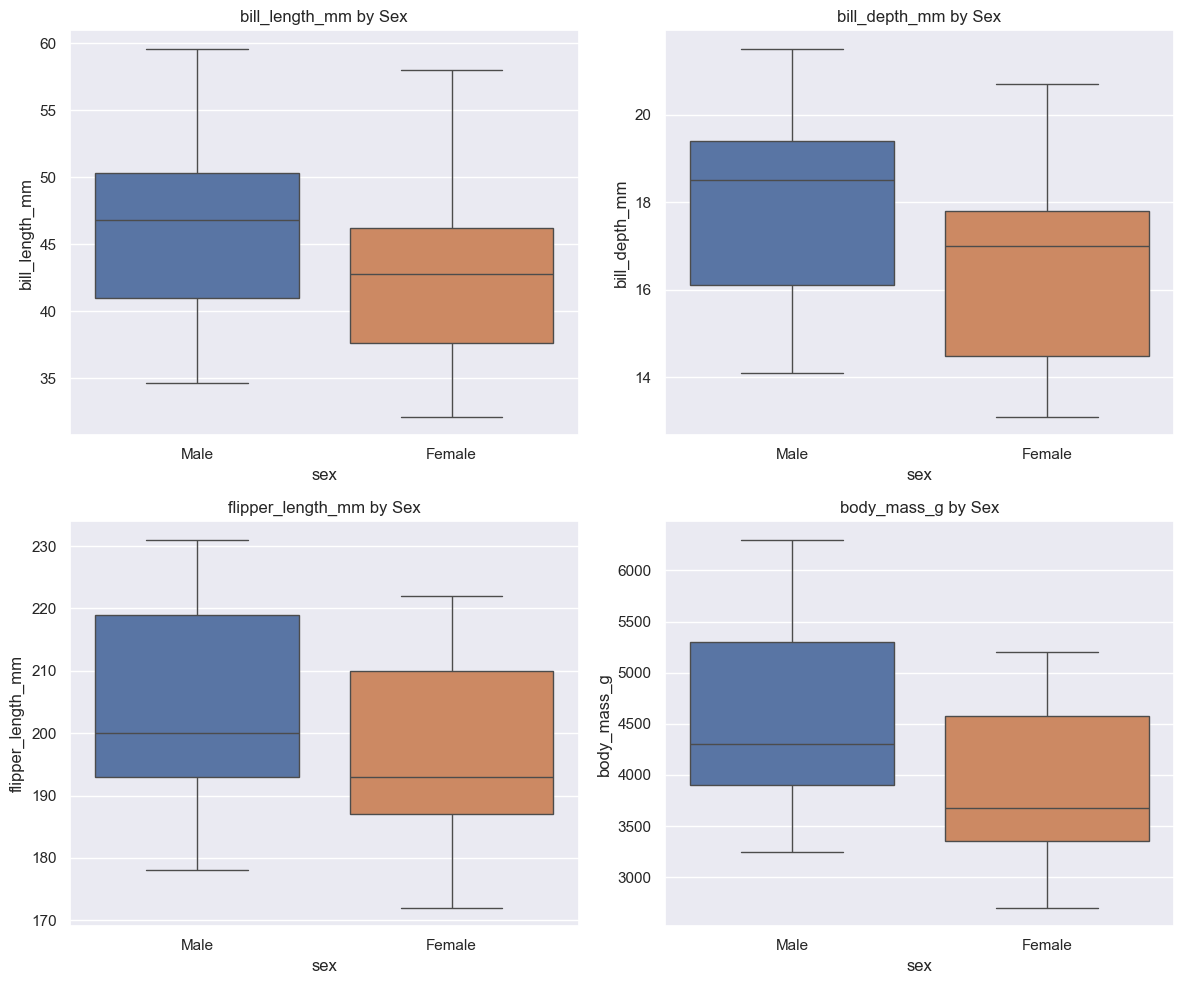

In [103]:
features = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

plt.figure(figsize=(12, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=datos_cleaned, x='sex', y=feature, hue='sex') #type: ignore
    plt.title(f'{feature} by Sex')

plt.tight_layout()
plt.show()

### Data cleaning
One hot encoding of variable sex

In [104]:
#### BORRADO DE VARIABLES CATEGORICAS Y ONE HOT ENCODING
datos_encoded = pd.get_dummies(datos_cleaned, columns=['sex'], drop_first=True)
#datos_encoded = datos_encoded.drop(columns=['species', 'island'])

In [105]:
datos_encoded['sex_Male'] = datos_encoded['sex_Male'].astype(int)
variables_num = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex_Male']
datos_encoded.dtypes
datos_encoded.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex_Male
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,1
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,0
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,0
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,0
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,1


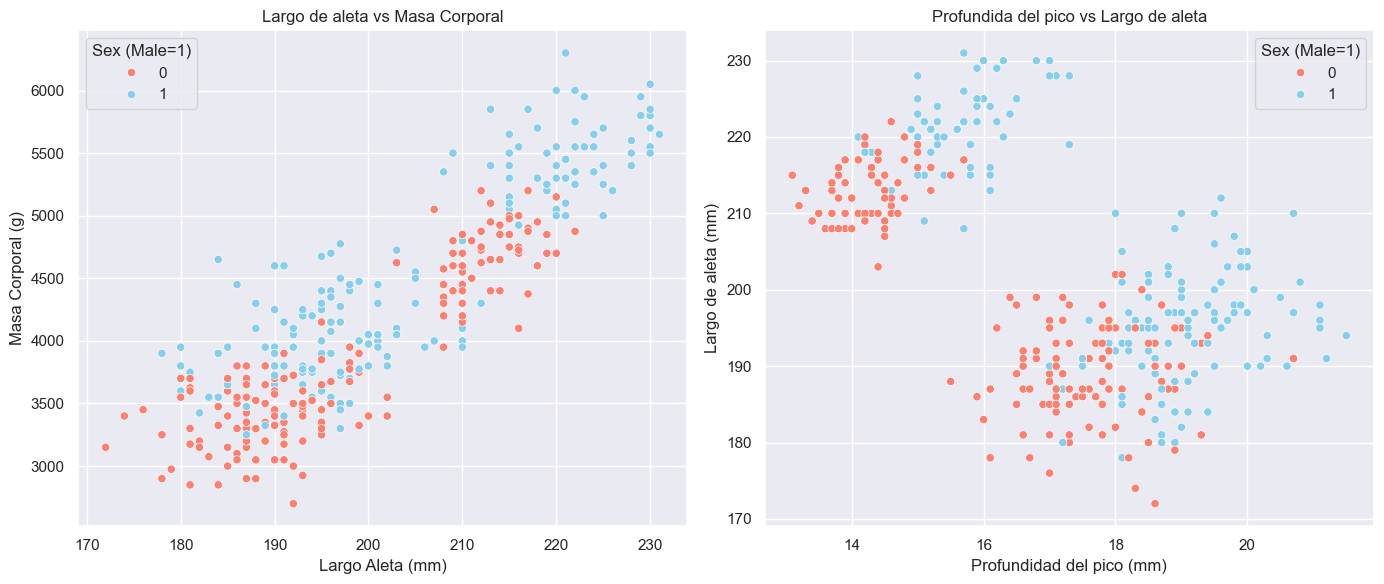

In [106]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Scatter 1: Positive correlation
sns.scatterplot(
    data=datos_encoded,
    x='flipper_length_mm',
    y='body_mass_g',
    hue='sex_Male',
    palette={0: 'salmon', 1: 'skyblue'},
    ax=axes[0]
)
axes[0].set_title('Largo de aleta vs Masa Corporal')
axes[0].set_xlabel('Largo Aleta (mm)')
axes[0].set_ylabel('Masa Corporal (g)')
axes[0].legend(title='Sex (Male=1)')

# Scatter 2: Negative correlation
sns.scatterplot(
    data=datos_encoded,
    x='bill_depth_mm',
    y='flipper_length_mm',
    hue='sex_Male',
    palette={0: 'salmon', 1: 'skyblue'},
    ax=axes[1]
)
axes[1].set_title('Profundida del pico vs Largo de aleta')
axes[1].set_xlabel('Profundidad del pico (mm)')
axes[1].set_ylabel('Largo de aleta (mm)')
axes[1].legend(title='Sex (Male=1)')

plt.tight_layout()
plt.show()

                   bill_length_mm  bill_depth_mm  flipper_length_mm  \
bill_length_mm           1.000000      -0.235053           0.656181   
bill_depth_mm           -0.235053       1.000000          -0.583851   
flipper_length_mm        0.656181      -0.583851           1.000000   
body_mass_g              0.595110      -0.471916           0.871202   
sex_Male                 0.346286       0.377707           0.246715   

                   body_mass_g  sex_Male  
bill_length_mm        0.595110  0.346286  
bill_depth_mm        -0.471916  0.377707  
flipper_length_mm     0.871202  0.246715  
body_mass_g           1.000000  0.422340  
sex_Male              0.422340  1.000000  


<Axes: >

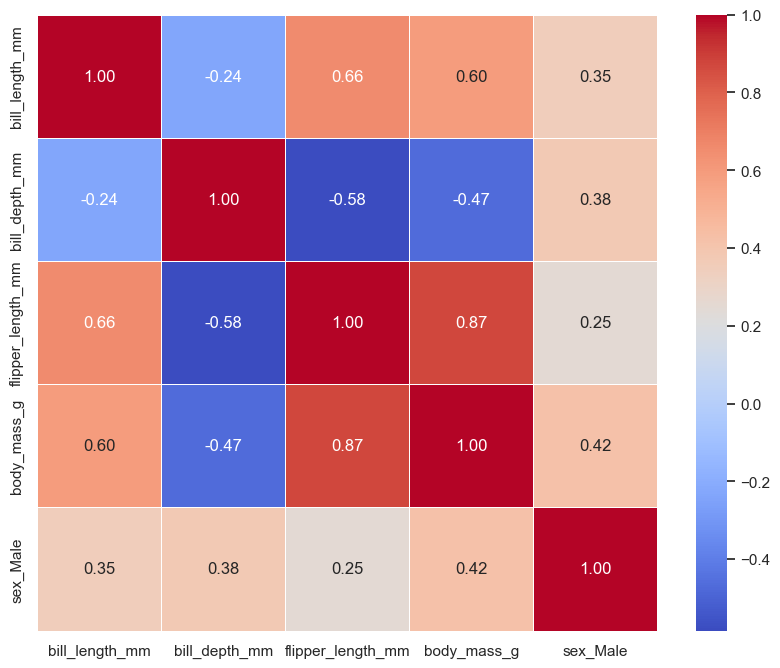

In [107]:
R = datos_encoded[variables_num].corr()
print(R)
plt.figure(figsize=(10, 8))
sns.heatmap(R, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# PCA

In [108]:
#Arrancamos con PCA
#Definimos X como el dataset donde ejecutaremos el PCA. (Variables continuas)
X = datos_encoded[variables_num]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Crea una instancia de Análisis de Componentes Principales (ACP):
# - Utilizamos PCA(n_components=7) para crear un objeto PCA que realizará un análisis de componentes principales.
# - Establecemos n_components en 7 para retener el maximo de las componentes principales (maximo= numero de variables).
pca = PCA(n_components=5)

# Aplicar el Análisis de Componentes Principales (ACP) a los datos estandarizados:
# - Usamos pca.fit(notas_std) para ajustar el modelo de ACP a los datos estandarizados.
fit = pca.fit(X_scaled)

# Obtener los autovalores asociados a cada componente principal.
autovalores = fit.explained_variance_
autovalores

# Obtener la varianza explicada por cada componente principal como un porcentaje de la varianza total.
var_explicada = fit.explained_variance_ratio_
# Por ejemplo podemos ver que la varianza explicada por tres CP es:
var_explicada_2 = np.sum(var_explicada[:2])
var_explicada_2

# Calcular la varianza explicada acumulada a medida que se agregan cada componente principal.
var_acumulada = np.cumsum(var_explicada)
var_acumulada

# Crear un DataFrame de pandas con los datos anteriores y establecer índice.
data = {'Autovalores': autovalores, 'Variabilidad Explicada': var_explicada, 'Variabilidad Acumulada': var_acumulada}
tabla = pd.DataFrame(data, index=['Componente {}'.format(i) for i in range(1, fit.n_components_+1)])

# Imprimir la tabla
print(tabla)

              Autovalores  Variabilidad Explicada  Variabilidad Acumulada
Componente 1     2.848496                0.568034                0.568034
Componente 2     1.417004                0.282572                0.850606
Componente 3     0.477807                0.095282                0.945887
Componente 4     0.170808                0.034062                0.979949
Componente 5     0.100548                0.020051                1.000000


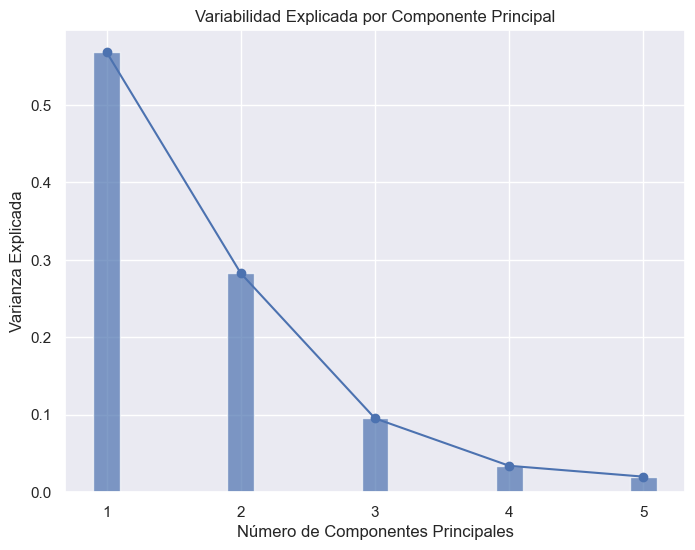

In [109]:
#VARIANZA EXPLICADA
# Representacion de la variabilidad explicada:

plot_varianza_explicada(var_explicada, fit.n_components_)

In [110]:
# Crea una instancia de ACP con las dos primeras componentes que nos interesan y aplicar a los datos.
pca2 = PCA(n_components=3)
fit2 = pca2.fit(X_scaled)

# Obtener los autovectores asociados a cada componente principal.
print(pca2.components_)

# Obtener los autovectores asociados a cada componente principal y transponerlos.
autovectores2 = pd.DataFrame(pca2.components_.T,
                            columns = ['Autovector {}'.format(i) for i in range(1, fit2.n_components_+1)],
                            index = ['{}_z'.format(variable) for variable in variables_num])

display(autovectores2)

[[ 0.46422293 -0.33455212  0.56334983  0.55341201  0.22123306]
 [ 0.17058278  0.64861949 -0.09565826  0.05311225  0.73363673]
 [ 0.84648324  0.16387065 -0.10769975 -0.36985502 -0.32896894]]


,Autovector 1,Autovector 2,Autovector 3
bill_length_mm_z,0.464223,0.170583,0.846483
bill_depth_mm_z,-0.334552,0.648619,0.163871
flipper_length_mm_z,0.563350,-0.095658,-0.107700
body_mass_g_z,0.553412,0.053112,-0.369855
sex_Male_z,0.221233,0.733637,-0.328969


In [111]:
### CREAR NUEVO DATAFRAME DE VARIABLES STANDARIZADAS + CATEGORICAS
# Crear DataFrame a partir del array X_scaled con nombres de columnas
X_scaled_df = pd.DataFrame(X_scaled, columns=variables_num)

# Concatenar con columnas categóricas
datos_z = pd.concat([datos_encoded[['species', 'island']], X_scaled_df], axis=1)

# Verificar
print(datos_z.head())

  species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen       -0.884499       0.785449          -1.418347   
1  Adelie  Torgersen       -0.811126       0.126188          -1.062250   
2  Adelie  Torgersen       -0.664380       0.430462          -0.421277   
4  Adelie  Torgersen       -0.847812       1.748985          -0.777373   
5  Adelie  Torgersen       -0.921185       0.329038          -1.418347   

   body_mass_g  sex_Male  
0    -0.564142  1.011765  
1    -0.501703 -0.988372  
2    -1.188532 -0.988372  
4    -0.689020  1.011765  
5    -0.720240 -0.988372  


In [112]:
# Paso 1: Eliminar nulos
datos_clean = datos_encoded.dropna(subset=variables_num + ['species', 'island'])

# Paso 2: Escalar solo variables numéricas
X = datos_clean[variables_num]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Renombrar columnas con sufijo _z para indicar estandarización
variables_num_z = [col + '_z' for col in variables_num]
X_scaled_df = pd.DataFrame(X_scaled, columns=variables_num_z, index=datos_clean.index)


# Paso 3: Aplicar PCA
pca2 = PCA(n_components=3)
fit2 = pca2.fit(X_scaled_df)
resultados_pca = pd.DataFrame(
    fit2.transform(X_scaled_df),
    columns=['Componente {}'.format(i) for i in range(1, fit2.n_components_ + 1)],
    index=datos_clean.index
)

# Paso 4: Concatenar categóricas + estandarizadas
datos_z = pd.concat([datos_clean[['species', 'island']], X_scaled_df], axis=1)
datos_z_cp = pd.concat([datos_z, resultados_pca], axis=1)

# Mostrar resultado
display(datos_z_cp.head())


,species,island,bill_length_mm_z,bill_depth_mm_z,flipper_length_mm_z,body_mass_g_z,sex_Male_z,Componente 1,Componente 2,Componente 3
0,Adelie,Torgersen,-0.884499,0.785449,-1.418347,-0.564142,1.011765,-1.560771,1.206559,-0.591434
1,Adelie,Torgersen,-0.811126,0.126188,-1.062250,-0.501703,-0.988372,-1.513487,-0.706656,-0.040821
2,Adelie,Torgersen,-0.664380,0.430462,-0.421277,-1.188532,-0.988372,-1.566167,-0.582058,0.318253
4,Adelie,Torgersen,-1.324737,1.089724,-0.563715,-0.938776,-0.988372,-2.035302,-0.240204,-0.209727
5,Adelie,Torgersen,-0.847812,1.748985,-0.777373,-0.689020,1.011765,-1.574110,1.769838,-0.425330


In [113]:
# Seleccionamos solo las variables numéricas estandarizadas (sin categóricas)
variables_numericas_estandarizadas = X_scaled_df  # Ya estandarizadas
componentes_pca = resultados_pca  # Ya generadas con PCA

# Concatenar para calcular correlación
df_corr = pd.concat([variables_numericas_estandarizadas, componentes_pca], axis=1)

# Calcular la matriz de correlación
correlacion = df_corr.corr()

variables_num_z = [var + '_z' for var in variables_num]
# Extraer submatriz: correlación de variables vs componentes
correlaciones_var_comp = correlacion.loc[variables_num_z, componentes_pca.columns]

# Mostrar
display(correlaciones_var_comp)

,Componente 1,Componente 2,Componente 3
bill_length_mm_z,0.782345,0.202761,0.584263
bill_depth_mm_z,-0.563814,0.770974,0.113107
flipper_length_mm_z,0.949402,-0.113703,-0.074337
body_mass_g_z,0.932654,0.063131,-0.255283
sex_Male_z,0.372840,0.872029,-0.227062


In [114]:
##ELEVAMOS AL CUADRADO LAS CORRELACIONES
cos2 = correlaciones_var_comp**2
display(cos2)

,Componente 1,Componente 2,Componente 3
bill_length_mm_z,0.612064,0.041112,0.341364
bill_depth_mm_z,0.317886,0.594401,0.012793
flipper_length_mm_z,0.901364,0.012928,0.005526
body_mass_g_z,0.869843,0.003986,0.065169
sex_Male_z,0.139009,0.760434,0.051557


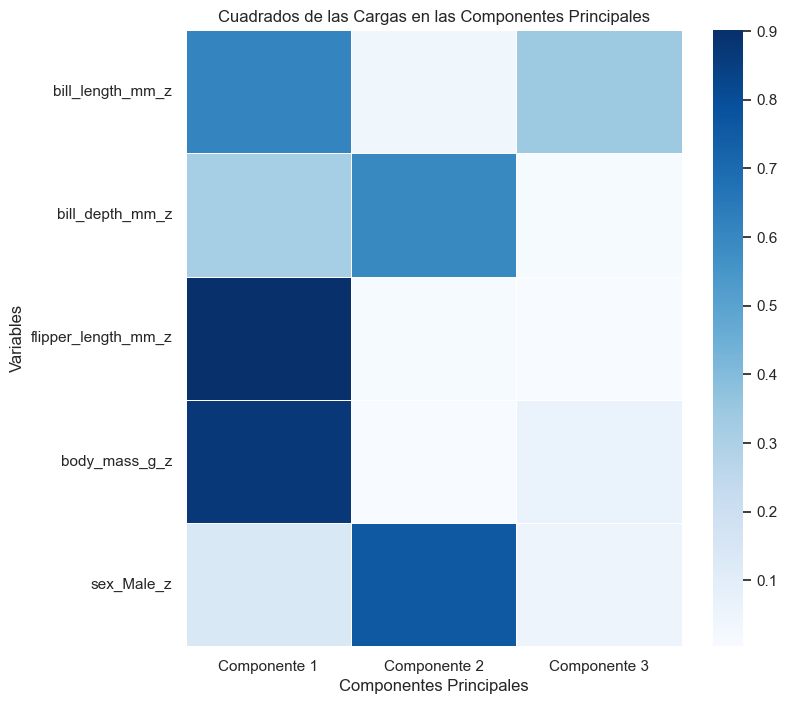

In [115]:
#HACEMOS GRAFICO
plot_cos2_heatmap(cos2)

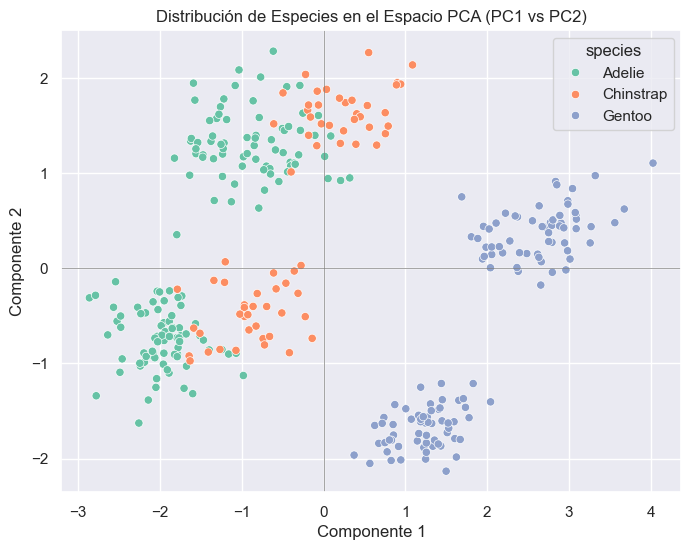

In [116]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=datos_z_cp,
    x='Componente 1',
    y='Componente 2',
    hue='species',
    palette='Set2'
)
plt.axhline(0, color='gray', lw=0.5)
plt.axvline(0, color='gray', lw=0.5)
plt.title('Distribución de Especies en el Espacio PCA (PC1 vs PC2)')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.grid(True)
plt.show()

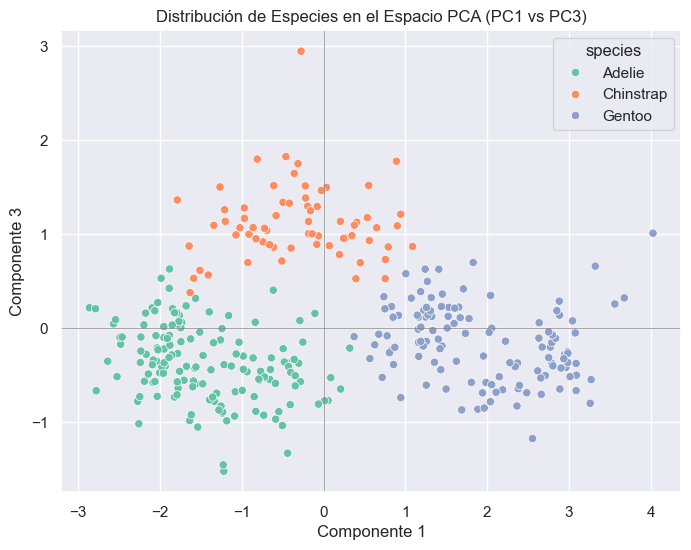

In [117]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=datos_z_cp,
    x='Componente 1',
    y='Componente 3',
    hue='species',
    palette='Set2'
)
plt.axhline(0, color='gray', lw=0.5)
plt.axvline(0, color='gray', lw=0.5)
plt.title('Distribución de Especies en el Espacio PCA (PC1 vs PC3)')
plt.xlabel('Componente 1')
plt.ylabel('Componente 3')
plt.grid(True)
plt.show()

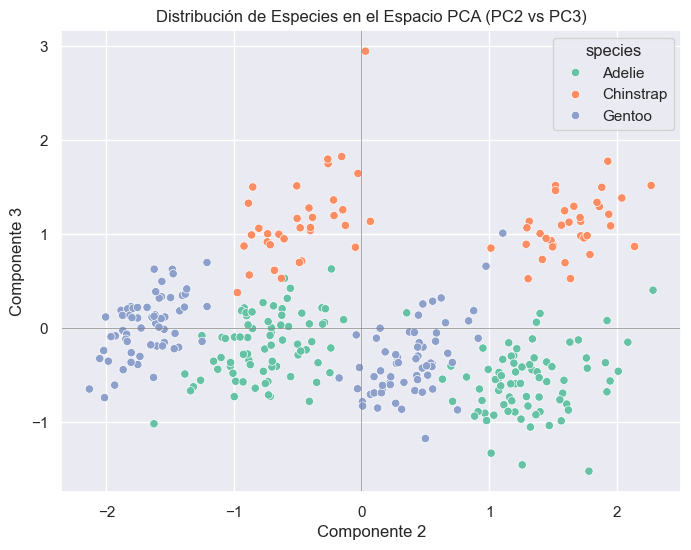

In [118]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=datos_z_cp,
    x='Componente 2',
    y='Componente 3',
    hue='species',
    palette='Set2'
)
plt.axhline(0, color='gray', lw=0.5)
plt.axvline(0, color='gray', lw=0.5)
plt.title('Distribución de Especies en el Espacio PCA (PC2 vs PC3)')
plt.xlabel('Componente 2')
plt.ylabel('Componente 3')
plt.grid(True)
plt.show()

In [119]:
datos_z_cp['indice_fisico'] = datos_z_cp['Componente 1']
indice_promedio = datos_z_cp.groupby('species')['indice_fisico'].mean()
print(indice_promedio)

species
Adelie      -1.427559
Chinstrap   -0.322691
Gentoo       1.930931
Name: indice_fisico, dtype: float64


# CLUSTERING

In [ ]:
datos_z_cp = datos_z_cp.drop(columns=['indice_fisico'])

In [132]:
datos_z_cp.dtypes
variables_num_z2= datos_z_cp.select_dtypes(include='float64').columns
variables_num_z2 = list(variables_num_z2)
print(variables_num_z2)

['bill_length_mm_z', 'bill_depth_mm_z', 'flipper_length_mm_z', 'body_mass_g_z', 'sex_Male_z', 'Componente 1', 'Componente 2', 'Componente 3']


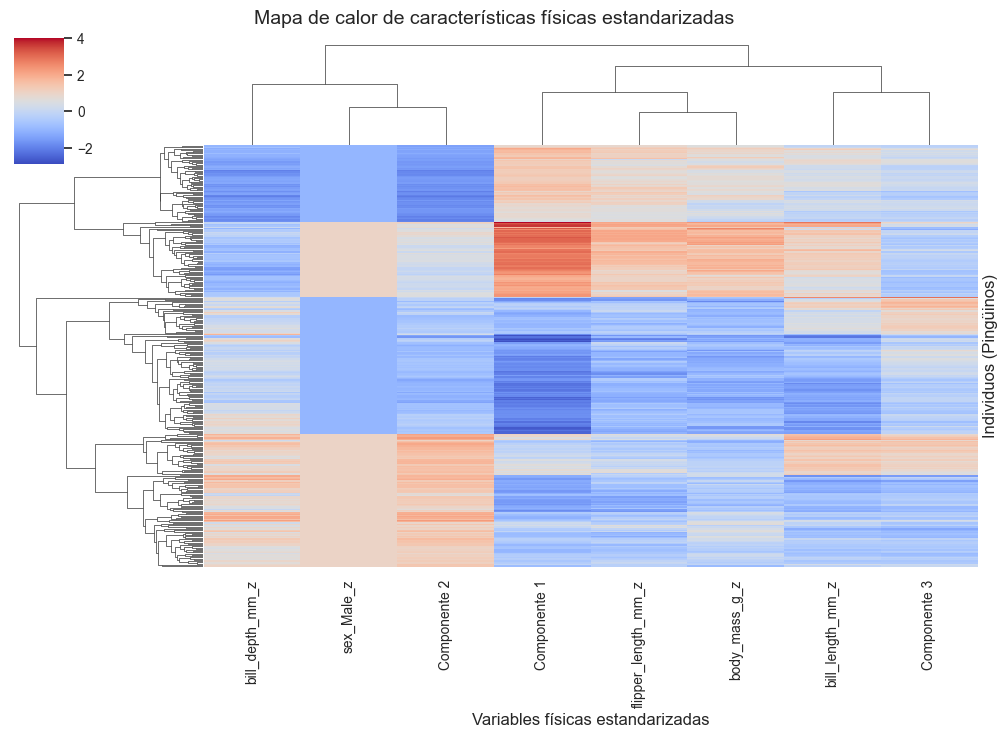

In [136]:
# Configuración de estilo
sns.set(font_scale=0.9)  # Ajusta el tamaño del texto
sns.set_style("white")
g = sns.clustermap(
    datos_z_cp[variables_num_z2],
    cmap='coolwarm',
    annot=False,           # Evita sobrecargar con números
    figsize=(10, 7),
    row_cluster=True,
    col_cluster=True,
    yticklabels=False      # Quita etiquetas de las filas si hay muchas
)
g.fig.suptitle("Mapa de calor de características físicas estandarizadas", fontsize=14, y=1.02)
g.ax_heatmap.set_xlabel("Variables físicas estandarizadas", fontsize=12)
g.ax_heatmap.set_ylabel("Individuos (Pingüinos)", fontsize=12)
plt.show()

In [139]:
##DISTANCIA EUCLIDIANA Y DEONDROGRAMA
distance_std = distance.cdist(datos_z_cp[variables_num_z2], datos_z_cp[variables_num_z2],"euclidean")
print(distance_std[:5,:5].round(2))

[[0.   2.92 3.1  2.76 1.3 ]
 [2.92 0.   1.07 1.47 3.61]
 [3.1  1.07 0.   1.25 3.5 ]
 [2.76 1.47 1.25 0.   3.01]
 [1.3  3.61 3.5  3.01 0.  ]]


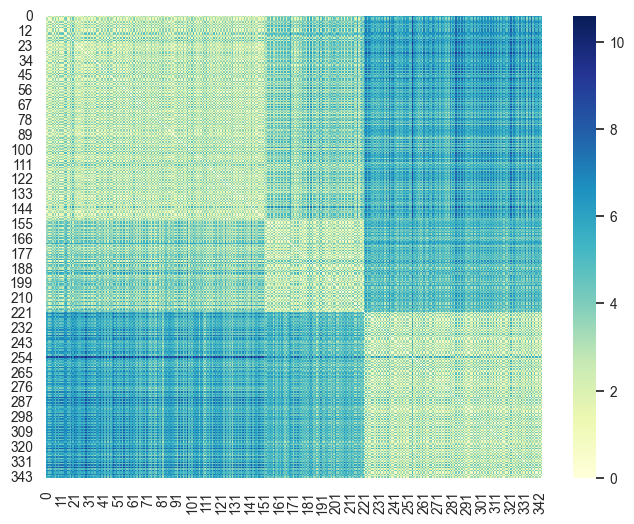

In [141]:
plt.figure(figsize=(8, 6))
df_std_distance = pd.DataFrame(distance_std, index = datos_z_cp.index, columns = datos_z_cp.index)
sns.heatmap(df_std_distance, annot=False, cmap="YlGnBu", fmt=".1f")
plt.show()

c:\Users\jesnavar\python\mineriaDatos\venv\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\jesnavar\python\mineriaDatos\venv\Lib\site-packages\seaborn\matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
c:\Users\jesnavar\python\mineriaDatos\venv\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\jesnavar\python\mineriaDatos\venv\Lib\site-packages\seaborn\matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
c:\Users\jesnavar\python\mineriaDatos\venv\L

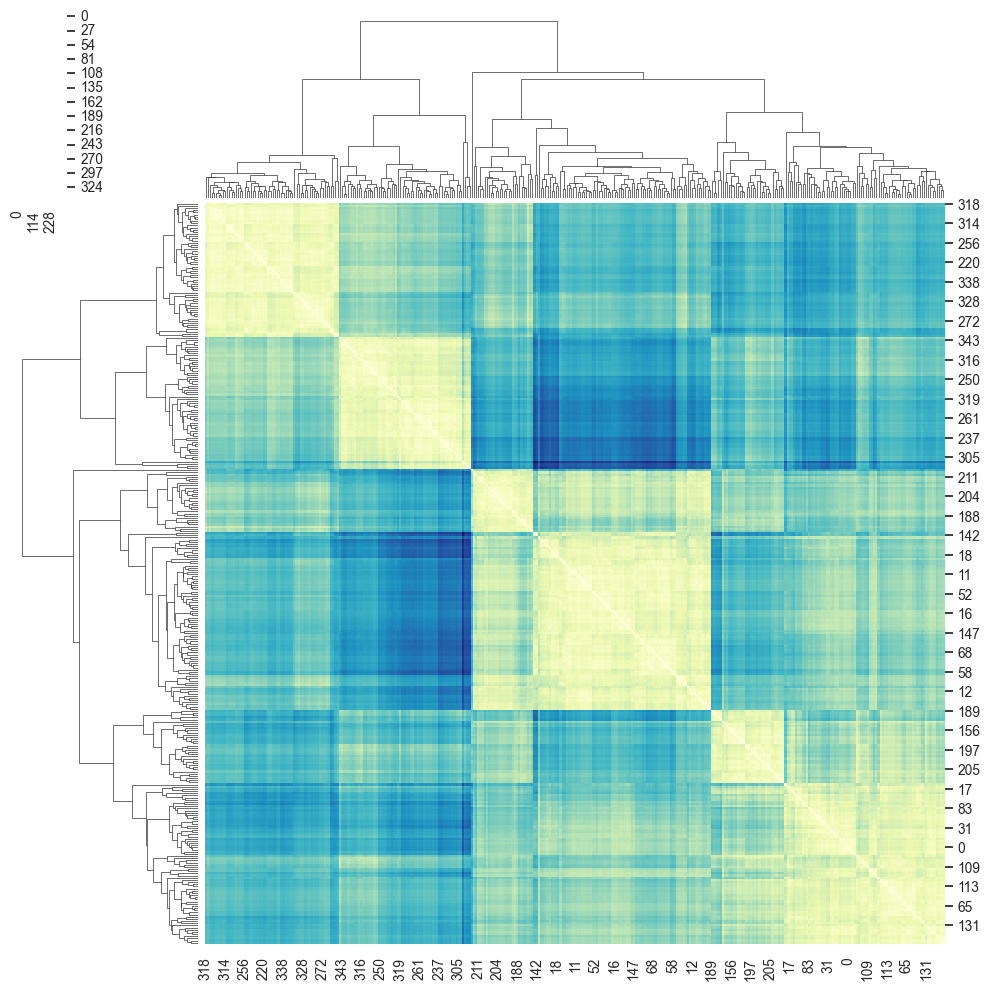

In [142]:
# Perform hierarchical clustering to get the linkage matrix
linkage = sns.clustermap(df_std_distance, cmap="YlGnBu", fmt=".1f", annot=False, method='average').dendrogram_row.linkage

# Reorder the data based on the hierarchical clustering
order = pd.DataFrame(linkage, columns=['cluster_1', 'cluster_2', 'distance', 'new_count']).index
reordered_data = datos_z_cp.reindex(index=order, columns=order)

# Optionally, you can add color bar
sns.heatmap(reordered_data, cmap="YlGnBu", fmt=".1f", cbar=False)
plt.show()

C:\Users\jesnavar\AppData\Local\Temp\ipykernel_15708\94640320.py:2: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = sch.linkage(df_std_distance, method='ward')  # You can choose a different linkage method if needed


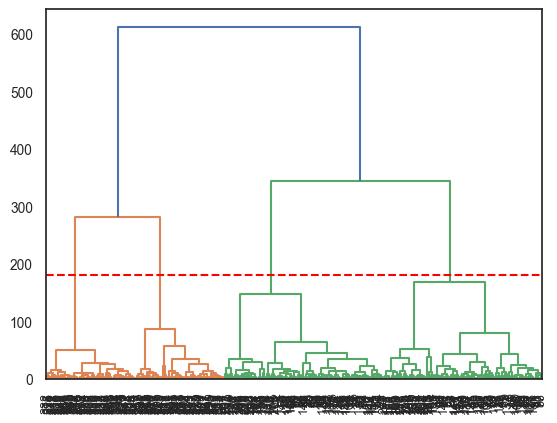

In [146]:
# Calculate the linkage matrix
linkage_matrix = sch.linkage(df_std_distance, method='ward')  # You can choose a different linkage method if needed

# Create the dendrogram
dendrogram = sch.dendrogram(linkage_matrix, labels=datos_z_cp.index, leaf_font_size=9, leaf_rotation=90)
plt.axhline(y=180, color='red', linestyle='--', label='Corte para 4 grupos')
# Display the dendrogram
plt.show()

C:\Users\jesnavar\AppData\Local\Temp\ipykernel_15708\1598353880.py:2: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = sch.linkage(df_std_distance, method='ward')


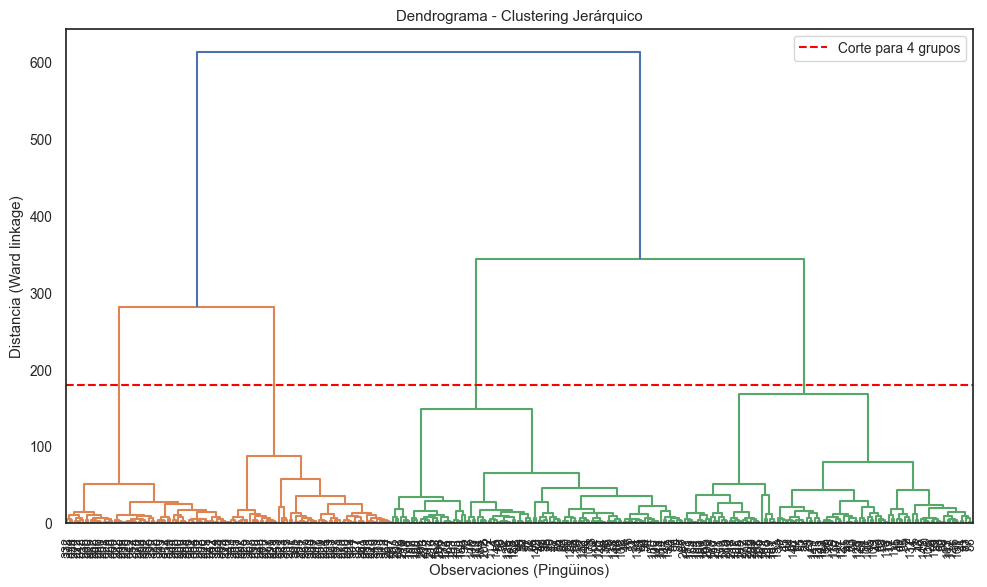

In [149]:
# Calcular la matriz de enlace
linkage_matrix = sch.linkage(df_std_distance, method='ward')

# Crear el dendrograma
plt.figure(figsize=(10, 6))
dendrogram = sch.dendrogram(
    linkage_matrix,
    labels=datos_z_cp.index,
    leaf_font_size=9,
    leaf_rotation=90
)

# Línea horizontal en altura 300 para mostrar corte en 3 grupos
plt.axhline(y=180, color='red', linestyle='--', label='Corte para 4 grupos')

plt.title("Dendrograma - Clustering Jerárquico")
plt.xlabel("Observaciones (Pingüinos)")
plt.ylabel("Distancia (Ward linkage)")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

C:\Users\jesnavar\AppData\Local\Temp\ipykernel_15708\1413961503.py:2: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = sch.linkage(df_std_distance, method='ward')


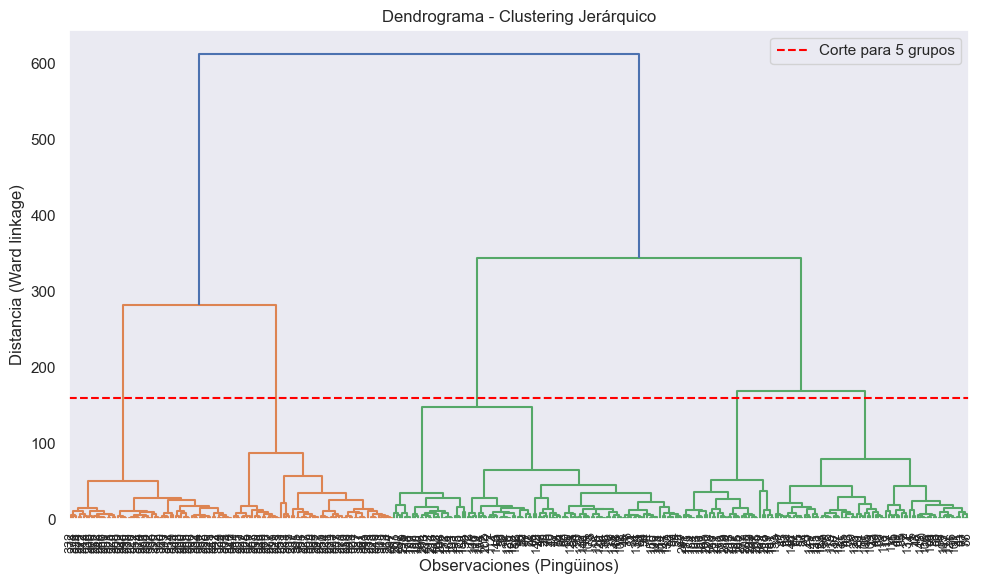

In [155]:
# Calcular la matriz de enlace
linkage_matrix = sch.linkage(df_std_distance, method='ward')

# Crear el dendrograma
plt.figure(figsize=(10, 6))
dendrogram = sch.dendrogram(
    linkage_matrix,
    labels=datos_z_cp.index,
    leaf_font_size=9,
    leaf_rotation=90
)

# Línea horizontal en altura 300 para mostrar corte en 3 grupos
plt.axhline(y=160, color='red', linestyle='--', label='Corte para 5 grupos')

plt.title("Dendrograma - Clustering Jerárquico")
plt.xlabel("Observaciones (Pingüinos)")
plt.ylabel("Distancia (Ward linkage)")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

In [150]:
# Assign data points to 4 clusters
num_clusters = 4
cluster_assignments = sch.fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Display the cluster assignments
print("Cluster Assignments:", cluster_assignments)

# Display the dendrogram
plt.show()

Cluster Assignments: [4 3 3 3 4 3 4 3 4 3 3 3 4 4 3 3 4 3 4 3 4 3 4 4 3 4 3 3 4 3 4 3 4 3 4 4 3
 3 4 3 4 3 4 3 4 4 3 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3
 4 3 4 3 4 3 4 3 4 3 4 4 3 4 3 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4
 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 4 3 3
 4 3 4 3 4 4 3 4 3 3 4 3 4 3 4 3 4 3 4 4 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4
 4 3 3 4 3 4 4 3 4 3 3 4 3 4 4 3 3 4 3 4 3 4 3 4 4 3 4 3 3 4 3 4 4 3 1 2 1
 2 2 1 1 2 1 2 1 2 1 2 1 2 1 2 1 2 2 1 1 2 1 2 1 2 1 2 2 1 1 2 1 2 1 2 1 2
 1 2 1 2 2 1 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 2 1 1 2 1
 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 2 1 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2
 1 2 1 2 1 1 2 1 2]


In [153]:
#Create an array to store the WCSS values for different values of K:
wcss = []

for k in range(1, 11):  # You can choose a different range of K values
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(datos_z_cp[variables_num_z2])
    wcss.append(kmeans.inertia_)  # Inertia is the WCSS value

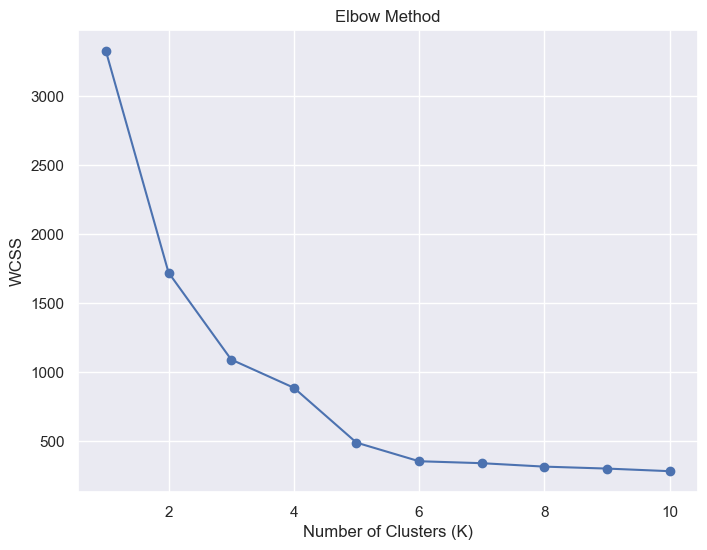

In [154]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='-', color='b')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

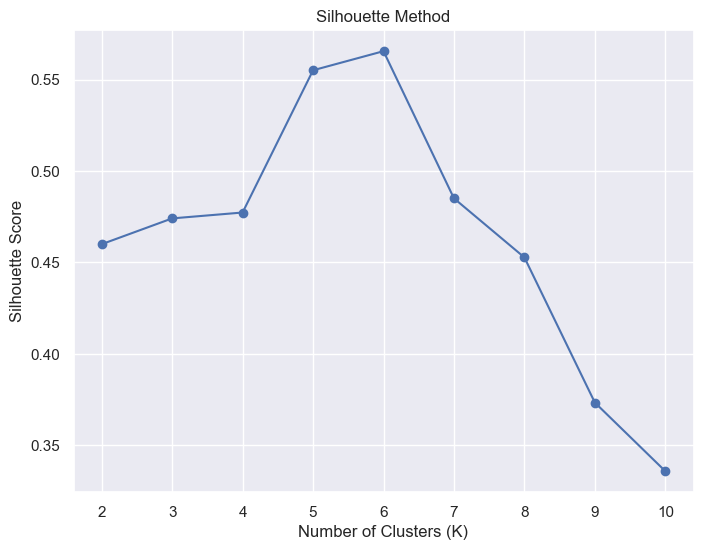

In [157]:
silhouette_scores = []

#Run K-means clustering for a range of K values and calculate the silhouette score for each K:

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(datos_z_cp[variables_num_z2])
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(datos_z_cp[variables_num_z2], labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='-', color='b')
plt.title('Silhouette Method')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

In [ ]:
#ASIGNACION DE CLUSTER JERARQUICO 5 GRUPOS
num_clusters = 5
cluster_assignments = sch.fcluster(linkage_matrix, num_clusters, criterion='maxclust')
# Display the cluster assignments
print("Cluster Assignments:", cluster_assignments)
# Display the dendrogram
plt.show()
#ASIGNAR CLUSTER A NUESTRO DATAFRAME
datos_z_cp['jerarquico'] = cluster_assignments
datos_z_cp['jerarquico']

Cluster Assignments: [5 3 3 3 5 3 5 3 5 3 3 3 5 5 3 3 5 3 5 3 5 3 5 5 3 5 3 3 5 3 5 3 5 3 5 5 3
 3 5 3 5 3 5 3 5 5 3 3 5 3 5 3 5 3 5 3 5 3 5 3 5 3 5 3 5 3 5 3 5 3 5 3 5 3
 5 3 5 3 5 3 5 3 5 3 5 5 3 5 3 3 5 3 5 3 5 3 5 3 5 3 5 3 5 3 5 3 5 3 5 3 5
 3 5 3 5 3 5 3 5 3 5 3 5 3 5 3 5 3 5 3 5 3 5 3 5 3 5 3 5 3 5 3 5 3 5 5 3 3
 5 3 5 3 4 4 3 4 3 3 4 3 4 3 4 3 4 3 4 4 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4
 4 3 3 4 3 4 4 3 4 3 3 4 3 4 4 3 3 4 3 4 3 4 3 4 4 3 4 3 3 4 3 4 4 3 1 2 1
 2 2 1 1 2 1 2 1 2 1 2 1 2 1 2 1 2 2 1 1 2 1 2 1 2 1 2 2 1 1 2 1 2 1 2 1 2
 1 2 1 2 2 1 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 2 1 1 2 1
 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 2 1 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2
 1 2 1 2 1 1 2 1 2]


0      5
1      3
2      3
4      3
5      5
      ..
338    1
340    1
341    2
342    1
343    2
Name: jerarquico, Length: 342, dtype: int32

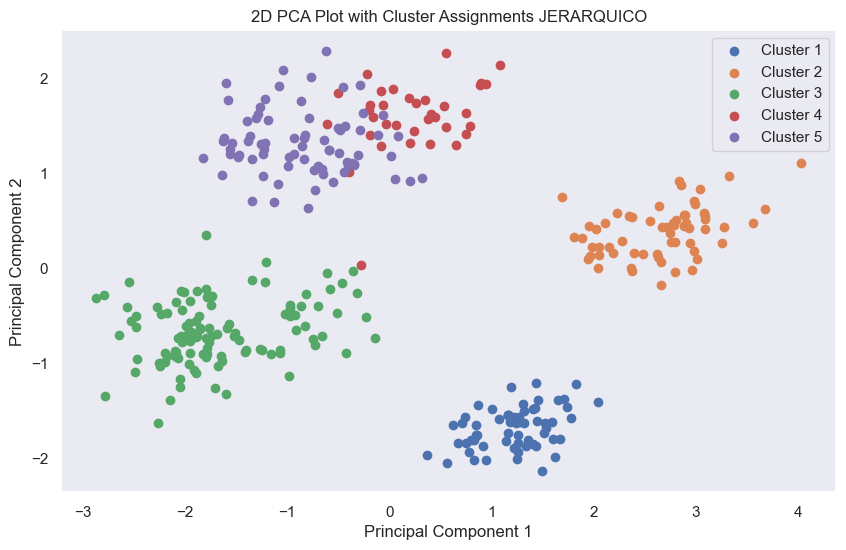

In [165]:
#GRAFICO ASIGNACION JERARQUICO VS PCA1 y PCA2

# Step 2: Create a scatter plot with colors for clusters
plt.figure(figsize=(10, 6))

# Loop through unique cluster assignments and plot data points with the same color
for cluster in np.unique(cluster_assignments):
    plt.scatter(datos_z_cp.loc[cluster_assignments == cluster, 'Componente 1'],
                datos_z_cp.loc[cluster_assignments == cluster, 'Componente 2'],
                label=f'Cluster {cluster}')
# Add labels to data points
#for i, row in datos_z_cp.iterrows():
    #plt.text(row['PC1'], row['PC2'], str(datos_z_cp.index[i]), fontsize=8)

plt.title("2D PCA Plot with Cluster Assignments JERARQUICO")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid()
plt.show()

In [168]:
#ASIGNACION DE CLUSTER K-MEANS 5 GRUPOS
k1 = 5
# Initialize the KMeans model
kmeans1 = KMeans(n_clusters=k1, random_state=0)
# Fit the KMeans model to your standardized data
kmeans1.fit(datos_z_cp[variables_num_z2])
# Get the cluster labels for your data
kmeans_cluster_labels = kmeans1.labels_
print(kmeans_cluster_labels)
datos_z_cp['kmeans_label'] = kmeans_cluster_labels
datos_z_cp['kmeans_label']

[2 3 3 3 2 3 2 3 2 3 3 3 2 2 3 3 2 3 2 3 2 3 2 2 3 2 3 3 2 3 2 3 2 3 2 2 3
 3 2 3 2 3 2 3 2 2 3 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3
 2 3 2 3 2 3 2 3 2 3 2 2 3 2 3 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2
 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 2 3 3
 2 3 2 3 0 0 3 0 3 3 0 3 0 3 0 3 0 3 0 0 0 3 0 3 0 3 0 3 0 0 0 3 0 3 0 3 0
 0 3 3 0 3 0 0 3 0 3 0 0 3 0 0 0 3 0 3 0 3 0 3 0 0 3 0 3 3 0 3 0 0 0 1 4 1
 4 4 1 1 4 1 4 1 4 1 4 1 4 1 4 1 4 4 1 1 4 1 4 1 4 1 4 4 1 1 4 1 4 1 4 1 4
 1 4 1 4 4 1 1 4 1 4 1 4 1 4 1 4 1 4 1 4 1 4 1 4 1 4 1 4 1 4 1 4 4 1 1 4 1
 4 1 4 1 4 1 4 1 4 1 4 1 4 1 4 1 4 1 4 4 1 1 4 1 4 1 4 1 4 1 4 1 4 1 4 1 4
 1 4 1 4 1 1 4 1 4]


0      2
1      3
2      3
4      3
5      2
      ..
338    1
340    1
341    4
342    1
343    4
Name: kmeans_label, Length: 342, dtype: int32

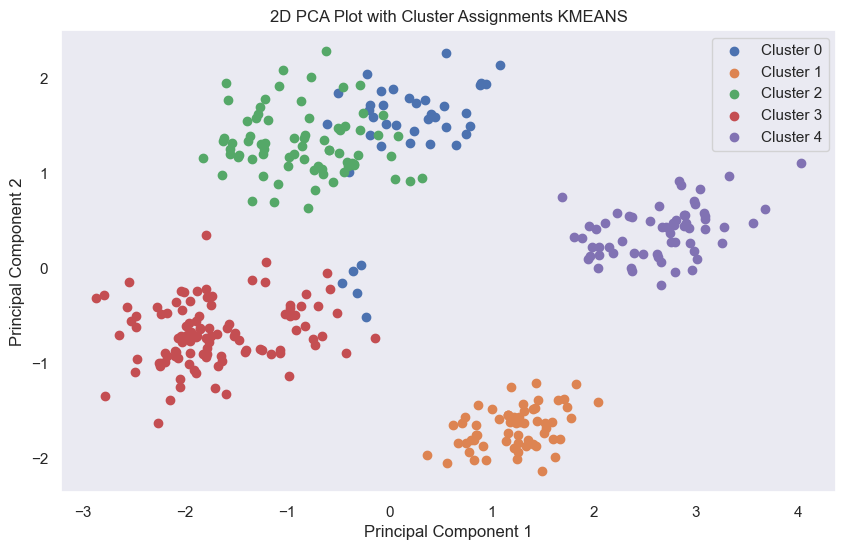

In [169]:
#GRAFICO ASIGNACION KMEANS VS PCA1 y PCA2

# Step 2: Create a scatter plot with colors for clusters
plt.figure(figsize=(10, 6))

# Loop through unique cluster assignments and plot data points with the same color
for cluster in np.unique(kmeans_cluster_labels):
    plt.scatter(datos_z_cp.loc[kmeans_cluster_labels == cluster, 'Componente 1'],
                datos_z_cp.loc[kmeans_cluster_labels == cluster, 'Componente 2'],
                label=f'Cluster {cluster}')
# Add labels to data points
#for i, row in datos_z_cp.iterrows():
    #plt.text(row['PC1'], row['PC2'], str(datos_z_cp.index[i]), fontsize=8)

plt.title("2D PCA Plot with Cluster Assignments KMEANS")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid()
plt.show()

In [171]:
datos_z_cp.head(20)

,species,island,bill_length_mm_z,bill_depth_mm_z,flipper_length_mm_z,body_mass_g_z,sex_Male_z,Componente 1,Componente 2,Componente 3,jerarquico,kmeans_label
0,Adelie,Torgersen,-0.884499,0.785449,-1.418347,-0.564142,1.011765,-1.560771,1.206559,-0.591434,5,2
1,Adelie,Torgersen,-0.811126,0.126188,-1.062250,-0.501703,-0.988372,-1.513487,-0.706656,-0.040821,3,3
2,Adelie,Torgersen,-0.664380,0.430462,-0.421277,-1.188532,-0.988372,-1.566167,-0.582058,0.318253,3,3
4,Adelie,Torgersen,-1.324737,1.089724,-0.563715,-0.938776,-0.988372,-2.035302,-0.240204,-0.209727,3,3
5,Adelie,Torgersen,-0.847812,1.748985,-0.777373,-0.689020,1.011765,-1.574110,1.769838,-0.425330,5,2
6,Adelie,Torgersen,-0.921185,0.329038,-1.418347,-0.720240,-0.988372,-1.953991,-0.571401,0.018435,3,3
7,Adelie,Torgersen,-0.866155,1.241861,-0.421277,0.590980,1.011765,-0.503991,1.471699,-1.035726,5,2
8,Adelie,Torgersen,-1.801661,0.481175,-0.563715,-0.907557,-0.988372,-2.035833,-0.714617,-0.724706,3,3
9,Adelie,Torgersen,-0.352544,1.546135,-0.777373,0.060248,1.011765,-0.861677,1.762546,-0.316456,5,2
10,Adelie,Torgersen,-1.122961,-0.025949,-1.062250,-1.126093,-0.988372,-1.952895,-0.891691,-0.098781,3,3


In [ ]:
datos_z_cp['sex'] = datos_cleaned['sex']

,species,island,bill_length_mm_z,bill_depth_mm_z,flipper_length_mm_z,body_mass_g_z,sex_Male_z,Componente 1,Componente 2,Componente 3,jerarquico,kmeans_label,sex
0,Adelie,Torgersen,-0.884499,0.785449,-1.418347,-0.564142,1.011765,-1.560771,1.206559,-0.591434,5,2,Male
1,Adelie,Torgersen,-0.811126,0.126188,-1.062250,-0.501703,-0.988372,-1.513487,-0.706656,-0.040821,3,3,Female
2,Adelie,Torgersen,-0.664380,0.430462,-0.421277,-1.188532,-0.988372,-1.566167,-0.582058,0.318253,3,3,Female
4,Adelie,Torgersen,-1.324737,1.089724,-0.563715,-0.938776,-0.988372,-2.035302,-0.240204,-0.209727,3,3,Female
5,Adelie,Torgersen,-0.847812,1.748985,-0.777373,-0.689020,1.011765,-1.574110,1.769838,-0.425330,5,2,Male
...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,Gentoo,Biscoe,0.601305,-1.750171,0.931890,0.903175,-0.988372,1.670810,-1.798902,0.112928,1,1,Female
340,Gentoo,Biscoe,0.527932,-1.445897,1.003109,0.809516,-0.988372,1.523243,-1.625847,0.127651,1,1,Female
341,Gentoo,Biscoe,1.188289,-0.735923,1.501644,1.933419,1.011765,2.937600,0.426679,-0.324380,2,4,Male
342,Gentoo,Biscoe,0.234440,-1.192335,0.789451,1.246590,-0.988372,1.423685,-1.467794,-0.217877,1,1,Female


In [176]:
# Jerárquico
print("Distribución por especie - Clustering Jerárquico")
print(pd.crosstab(datos_z_cp['species'], datos_z_cp['jerarquico'], normalize='columns') * 100)

# K-Means
print("\nDistribución por especie - K-Means")
print(pd.crosstab(datos_z_cp['species'], datos_z_cp['kmeans_label'], normalize='columns') * 100)

# Jerárquico
print("\nDistribución por sexo - Clustering Jerárquico")
print(pd.crosstab(datos_z_cp['sex'], datos_z_cp['jerarquico'], normalize='columns') * 100)

# K-Means
print("\nDistribución por sexo - K-Means")
print(pd.crosstab(datos_z_cp['sex'], datos_z_cp['kmeans_label'], normalize='columns') * 100)


Distribución por especie - Clustering Jerárquico
jerarquico      1      2     3      4      5
species                                     
Adelie        0.0    0.0  70.0    0.0  100.0
Chinstrap     0.0    0.0  30.0  100.0    0.0
Gentoo      100.0  100.0   0.0    0.0    0.0

Distribución por especie - K-Means
kmeans_label      0      1      2          3      4
species                                            
Adelie          0.0    0.0  100.0  72.641509    0.0
Chinstrap     100.0    0.0    0.0  27.358491    0.0
Gentoo          0.0  100.0    0.0   0.000000  100.0

Distribución por sexo - Clustering Jerárquico
jerarquico      1      2      3          4      5
sex                                              
Female      100.0    0.0  100.0   2.857143    0.0
Male          0.0  100.0    0.0  97.142857  100.0

Distribución por sexo - K-Means
kmeans_label          0      1      2      3      4
sex                                                
Female        12.820513  100.0    0.0  100.0  